In [1]:
import os
import time
import cv2
import mediapipe as mp
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import animation

In [2]:
LANDMARKS_TO_DRAW = (11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
                     22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32)
CONNECTIONS_TO_DRAW = ((11, 12), (11, 13), (13, 15), (15, 17), (15, 19), (15, 21),
                       (17, 19), (12, 14), (14, 16), (16, 18), (16, 20), (16, 22),
                       (18, 20), (11, 23), (12, 24), (23, 24), (23, 25), (24, 26),
                       (25, 27), (26, 28), (27, 29), (28, 30), (29, 31), (30, 32),
                       (27, 31), (28, 32))

In [3]:
def get_pixel_coordinates(x, y, img_width, img_height):
    x_px = min(int(np.floor(x * img_width)), img_width - 1)
    y_px = min(int(np.floor(y * img_height)), img_height - 1)
    
    return x_px, y_px

In [4]:
def draw_connections(img, landmarks, img_width, img_height, correctness, visibility_threshold=0.5):
    if not landmarks:
        return
    
    circle_color = (255, 0, 0) if correctness else (0, 0, 0)
    line_color = (255, 255, 255) if correctness else (0, 0, 255)
    line_thickness = 2
    cut_bins = [-np.inf, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, np.inf]
    cut_names = [10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
    
    px_coordinates = dict()
    for idx, landmark in enumerate(landmarks.landmark):
        if (idx not in LANDMARKS_TO_DRAW) or \
            (hasattr(landmark, 'visibility') and landmark.visibility < visibility_threshold):
            continue
        x_px, y_px = get_pixel_coordinates(landmark.x, landmark.y, img_width, img_height)
        px_coordinates[idx] = (x_px, y_px, landmark.z)
    
    for connection in CONNECTIONS_TO_DRAW:
        start_idx = connection[0]
        end_idx = connection[1]
        
        if start_idx not in px_coordinates.keys() or end_idx not in px_coordinates.keys():
            continue
        
        cv2.line(img, px_coordinates[start_idx][:-1], px_coordinates[end_idx][:-1],
                 line_color, line_thickness)
    
    for x, y, z in px_coordinates.values():
        circle_radius = pd.cut([z], cut_bins, labels=cut_names)[0]
        circle_border_radius = max(circle_radius + 1, int(circle_radius * 1.2))
        
        cv2.circle(img, (x, y), circle_border_radius, line_color, min(1, line_thickness))
        cv2.circle(img, (x, y), circle_radius, circle_color, min(1, line_thickness))

In [5]:
def draw_failure(img, img_width, img_height):
    line_color = (0, 0, 255)
    line_thickness = 5
    
    cv2.rectangle(img, (0, 0), (img_width, img_height), line_color, line_thickness)

In [15]:
def image_resize(image, width=None, height=None, inter=cv2.INTER_AREA):
    dim = None
    (h, w) = image.shape[:2]

    if width is None and height is None:
        return image

    if width is None:
        r = height / float(h)
        dim = (int(w * r), height)

    else:
        r = width / float(w)
        dim = (width, int(h * r))

    resized = cv2.resize(image, dim, interpolation = inter)
    return resized, *dim

In [7]:
y_pred = [1 for _ in range(283)] + [0 for _ in range(32)] + [1 for _ in range(65)] + [0 for _ in range(35)] + [1 for _ in range(203)]

In [13]:
def pose_from_video_custom(video_path,
                             min_detection_confidence=0.5,
                             model_complexity=1,
                             min_tracking_confidence=0.5):

    mp_pose = mp.solutions.pose
    mp_drawing = mp.solutions.drawing_utils
    
    video = cv2.VideoCapture(video_path)
    n_frames = video.get(cv2.CAP_PROP_FRAME_COUNT)
    fps = video.get(cv2.CAP_PROP_FPS)
    width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    print(fps, n_frames, width, height)
    t1 = 0
    
    with mp_pose.Pose(min_detection_confidence=min_detection_confidence,
                      model_complexity=model_complexity,
                      min_tracking_confidence=min_tracking_confidence) as pose:
        i = 0
        while video.isOpened():
            ret, frame = video.read()
        
            if ret:
                t2 = time.time()
                fps = int(1 / (t2 - t1))
                t1 = t2
                
                frame = frame[::-1, ::-1, :]
#                 frame, width, height = image_resize(frame, height=680)
                
                frame.flags.writeable = False
                img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                results = pose.process(img)
                correctness = y_pred[i]

                img.flags.writeable = True
                img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

#                 mp_drawing.draw_landmarks(img, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
#                                           mp_drawing.DrawingSpec(color=(255, 0, 0), thickness=2, circle_radius=2),
#                                           mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=2, circle_radius=2))    
                draw_connections(img, results.pose_landmarks, width, height, correctness)
                
                if not correctness:
                    draw_failure(img, width, height)
                    cv2.putText(img, "Don't let your knees cave inward!", (40, 80),
                                cv2.FONT_HERSHEY_SIMPLEX, 1.9, (0, 0, 255), 5)
                    

#                 cv2.putText(img, f'FPS: {fps}', (width - 70, height - 5),
#                             cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
                cv2.imshow('POSE', img)
                i += 1

                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
            else:
                break
    
    video.release()
    cv2.destroyAllWindows()

In [11]:
pose_from_video_custom('.\\data\\sample_data\\20220719_214059.mp4', model_complexity=1)

29.994936129984527 618.0 1080 1920


In [58]:
def capture_pose_from_camera(min_detection_confidence=0.5,
                             model_complexity=1,
                             min_tracking_confidence=0.5,
                             enable_segmentation=False,
                             camera=0):
    width = 720
    height = 480
    
    mp_pose = mp.solutions.pose
    mp_drawing = mp.solutions.drawing_utils
    cap = cv2.VideoCapture(camera)
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, width)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, height)
    t1 = 0
    
    with mp_pose.Pose(min_detection_confidence=min_detection_confidence,
                      model_complexity=model_complexity,
                      min_tracking_confidence=min_tracking_confidence) as pose:
        
        while cap.isOpened():
            ret, frame = cap.read()
            
            t2 = time.time()
            fps = int(1 / (t2 - t1))
            t1 = t2

            frame.flags.writeable = False
            img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            results = pose.process(img)
            correctness = True

            img.flags.writeable = True
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

#             draw_connections(img, results.pose_landmarks, width, height, correctness)
            mp_drawing.draw_landmarks(img, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                      mp_drawing.DrawingSpec(color=(255, 0, 0), thickness=1, circle_radius=2),
                                      mp_drawing.DrawingSpec(color=(255, 255, 255), thickness=1, circle_radius=2))
            
            img = cv2.flip(img, 1)
            cv2.putText(img, f'FPS: {fps}', (width - 150, height - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
            cv2.imshow('POSE', img)

            if cv2.waitKey(10) & 0xFF == ord('q'):
                break

    cap.release()
    cv2.destroyAllWindows()

In [59]:
capture_pose_from_camera(0.5, 1, 0.5, False, camera=4)

In [9]:
def pose_from_video_to_file_corectness(input_path,
                            output_path,
                            min_detection_confidence=0.5,
                            model_complexity=1,
                            min_tracking_confidence=0.5):
    
    mp_pose = mp.solutions.pose
    video = cv2.VideoCapture(input_path)
    n_frames = video.get(cv2.CAP_PROP_FRAME_COUNT)
    width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = video.get(cv2.CAP_PROP_FPS)

    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height), True)

    with mp_pose.Pose(min_detection_confidence=min_detection_confidence,
                      min_tracking_confidence=min_tracking_confidence,
                      model_complexity=model_complexity) as pose:
        i = 0
        while video.isOpened():
            ret, frame = video.read()

            if ret:
                frame = frame[::-1, ::-1, :]
                
                frame.flags.writeable = False
                img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                results = pose.process(img)
                correctness = y_pred[i]

                img.flags.writeable = True
                img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
                
                draw_connections(img, results.pose_landmarks, width, height, correctness)

                if not correctness:
                    draw_failure(img, width, height)
                    cv2.putText(img, "Don't let your knees cave inward!", (40, 80),
                                cv2.FONT_HERSHEY_SIMPLEX, 1.9, (0, 0, 255), 5)
                
                out.write(img)
                cv2.imshow('POSE', img)
                i += 1

                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
            else:
                break

    video.release()
    out.release()
    cv2.destroyAllWindows()

In [16]:
pose_from_video_to_file_corectness('.\\data\\sample_data\\20220719_214059.mp4', '.\\data\\sample_data\\test2.mp4')

In [10]:
def pose_from_video_to_file(input_path,
                            output_path,
                            min_detection_confidence=0.5,
                            model_complexity=1,
                            min_tracking_confidence=0.5):
    
    mp_pose = mp.solutions.pose
    mp_drawing = mp.solutions.drawing_utils
    
    video = cv2.VideoCapture(input_path)
    n_frames = video.get(cv2.CAP_PROP_FRAME_COUNT)
    width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = video.get(cv2.CAP_PROP_FPS)

    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height), True)

    with mp_pose.Pose(min_detection_confidence=min_detection_confidence,
                      min_tracking_confidence=min_tracking_confidence,
                      model_complexity=model_complexity) as pose:

        while video.isOpened():
            ret, frame = video.read()

            if ret:
#                 frame = frame[::-1, ::-1, :]
                
                frame.flags.writeable = False
                img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                results = pose.process(img)

                img.flags.writeable = True
                img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
                
                mp_drawing.draw_landmarks(img, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                          mp_drawing.DrawingSpec(color=(255, 0, 0), thickness=1, circle_radius=2),
                                          mp_drawing.DrawingSpec(color=(255, 255, 255), thickness=1, circle_radius=2))
                
                out.write(img)
                cv2.imshow('POSE', img)

                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
            else:
                break

    video.release()
    out.release()
    cv2.destroyAllWindows()

In [56]:
pose_from_video_to_file('.//data//deadlift/2_deadlift_front.mp4',
                        '.\\data\\sample_data\\deadlift.mp4')

In [82]:
def capture_pose_from_video(video_path,
                             min_detection_confidence=0.5,
                             model_complexity=1,
                             min_tracking_confidence=0.5):

    mp_pose = mp.solutions.pose
    mp_drawing = mp.solutions.drawing_utils
    
    video = cv2.VideoCapture(video_path)
    n_frames = video.get(cv2.CAP_PROP_FRAME_COUNT)
    fps = video.get(cv2.CAP_PROP_FPS)
    width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    t1 = 0
    
    with mp_pose.Pose(min_detection_confidence=min_detection_confidence,
                      model_complexity=model_complexity,
                      min_tracking_confidence=min_tracking_confidence) as pose:
        while video.isOpened():
            ret, frame = video.read()
        
            if ret:
                t2 = time.time()
                fps = int(1 / (t2 - t1))
                t1 = t2
                
                frame = frame[::-1, ::-1, :]
                frame, width, height = image_resize(frame, height=500)
                
                frame.flags.writeable = False
                img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                results = pose.process(img)

                img.flags.writeable = True
                img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

                mp_drawing.draw_landmarks(img, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                          mp_drawing.DrawingSpec(color=(255, 0, 0), thickness=1, circle_radius=2),
                                          mp_drawing.DrawingSpec(color=(255, 255, 255), thickness=1, circle_radius=2))    
                
                cv2.putText(img, f'FPS: {fps}', (width - 70, height - 5),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
                cv2.imshow('POSE', img)

                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
            else:
                break
    
    video.release()
    cv2.destroyAllWindows()

In [83]:
capture_pose_from_video('.//data/sample_data/20220719_214059.mp4', model_complexity=1)


In [13]:
def merge_videos_and_save(video1_path, video2_path, output_path, output_height):
    def get_resized_aspect_ratio(width, height, new_width = None, new_height = None):
        if new_width is None and new_height is None:
            return width, height

        if new_width is None:
            r = new_height / float(height)
            dim = (int(width * r), new_height)

        else:
            r = new_width / float(width)
            dim = (new_width, int(height * r))

        return dim[0], dim[1]
    
    video1 = cv2.VideoCapture(video1_path)
    n_frames1 = video1.get(cv2.CAP_PROP_FRAME_COUNT)
    width1 = int(video1.get(cv2.CAP_PROP_FRAME_WIDTH))
    height1 = int(video1.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    video2 = cv2.VideoCapture(video2_path)
    n_frames2 = video2.get(cv2.CAP_PROP_FRAME_COUNT)
    width2 = int(video2.get(cv2.CAP_PROP_FRAME_WIDTH))
    height2 = int(video2.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    n_frames = min(n_frames1, n_frames2)
    new_w1, _ = get_resized_aspect_ratio(width1, height1, new_height=output_height)
    new_w2, _ = get_resized_aspect_ratio(width2, height2, new_height=output_height)
    output_width = new_w1 + new_w2
    
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(output_path, fourcc, 30, (output_width, output_height), True)
    
    while video1.isOpened() and video2.isOpened():
        ret1, frame1 = video1.read()
        ret2, frame2 = video2.read()
        
        if ret1 and ret2:
            frame1, _, _ = image_resize(frame1, height=output_height)
            frame2, _, _ = image_resize(frame2, height=output_height)
            
            merged = cv2.hconcat([frame1, frame2])
            
            out.write(merged)
            cv2.imshow('MERGED', merged)
            
            if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
        else:
            break
    
    video1.release()
    video2.release()
    out.release()
    cv2.destroyAllWindows()

In [37]:
exercise_path = './/data/sample_data/deadlift.mp4'
animation_path = './/data/sample_data/deadlift_animation.mp4'
output_path = './/data/sample_data/deadlift_merged.mp4'

merge_videos_and_save(exercise_path, animation_path, output_path, 720)

In [77]:
def get_data_from_video(video_path,
                        min_detection_confidence=0.5,
                        model_complexity=1,
                        min_tracking_confidence=0.5):

    mp_pose = mp.solutions.pose
    mp_drawing = mp.solutions.drawing_utils
    
    video = cv2.VideoCapture(video_path)
    n_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = int(video.get(cv2.CAP_PROP_FPS))
    width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    data = np.zeros((3, len(mp_pose.PoseLandmark), n_frames)) 
    t1 = 0
    frame_num = 0
    
    with mp_pose.Pose(min_detection_confidence=min_detection_confidence,
                      model_complexity=model_complexity,
                      min_tracking_confidence=min_tracking_confidence) as pose:
        while video.isOpened():
            ret, frame = video.read()
        
            if ret:
                t2 = time.time()
                fps = int(1 / (t2 - t1))
                t1 = t2
                
#                 frame = frame[::-1, ::-1, :]
                frame, width, height = image_resize(frame, height=680)
                
                frame.flags.writeable = False
                img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                results = pose.process(img)

                img.flags.writeable = True
                img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
                
                try:
                    landmarks = results.pose_world_landmarks.landmark
                    for i in range(len(mp_pose.PoseLandmark)):
                        data[:, i, frame_num] = (landmarks[i].x, landmarks[i].y, landmarks[i].z)
                except AttributeError:
                    data[:, :, frame_num] = np.zeros((3, len(mp_pose.PoseLandmark)))

                mp_drawing.draw_landmarks(img, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                          mp_drawing.DrawingSpec(color=(255, 0, 0), thickness=1, circle_radius=2),
                                          mp_drawing.DrawingSpec(color=(255, 255, 255), thickness=1, circle_radius=2))    
                
                cv2.putText(img, f'FPS: {fps}', (width - 70, height - 5),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
                cv2.imshow('POSE', img)
                frame_num += 1

                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
            else:
                break
    
    video.release()
    cv2.destroyAllWindows()
    
    return data

In [80]:
squat_path = './/data/sample_data/20220719_214059.mp4'
deadlift_path = './/data/deadlift/14_deadlift_front.mp4'

data = get_data_from_video(deadlift_path, model_complexity=1)
data.shape

(3, 33, 666)

### ANIMATION

In [39]:
pose_connections = mp.solutions.pose.POSE_CONNECTIONS

mp_pose = mp.solutions.pose
poselandmarks_list = []
for idx, elt in enumerate(mp_pose.PoseLandmark):
    lm_str = repr(elt).split('.')[1].split(':')[0]
    poselandmarks_list.append(lm_str)

In [79]:
def scale_axes(ax):
    ax.set_xlim3d([-1, 1])
    ax.set_ylim3d([-1, 1])
    ax.set_zlim3d([-1, 1])

    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])
    ax.axes.zaxis.set_ticklabels([])
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    ax.axes.zaxis.set_ticks([])

In [64]:
def time_animate(data, figure, ax, rotate_animation=True):
    frame_data = data[:, :, 0]

    plot = [ax.scatter(frame_data[0, :], -frame_data[2, :], -frame_data[1, :], color='tab:blue')]

    for i in pose_connections:
        plot.append(ax.plot3D([frame_data[0, i[0]], frame_data[0, i[1]]],
                              [-frame_data[2, i[0]], -frame_data[2, i[1]]],
                              [-frame_data[1, i[0]], -frame_data[1, i[1]]],
                              color='k', lw=1)[0])

    ax.view_init(elev=10, azim=160)
    scale_axes(ax)

    def init():
        return figure,

    def animate(i):
        frame_data = data[:, :, i]

        for idxx in range(len(plot)):
            plot[idxx].remove()

        plot[0] = ax.scatter(frame_data[0, :], -frame_data[2, :], -frame_data[1, :], color='tab:blue')

        idx = 1
        for pse in pose_connections:
            plot[idx] = ax.plot3D([frame_data[0, pse[0]], frame_data[0, pse[1]]],
                                  [-frame_data[2, pse[0]], -frame_data[2, pse[1]]],
                                  [-frame_data[1, pse[0]], -frame_data[1, pse[1]]],
                                  color='k', lw=1)[0]
            idx += 1

        if rotate_animation:
            ax.view_init(elev=10., azim=45 + (90 / data.shape[-1]) * i)

        return figure,

    # Animate
    anim = animation.FuncAnimation(figure, animate, init_func=init,
                                   frames=data.shape[2], interval=20, blit=True)

#     plt.close()
    plt.show()

    return anim

<IPython.core.display.Javascript object>


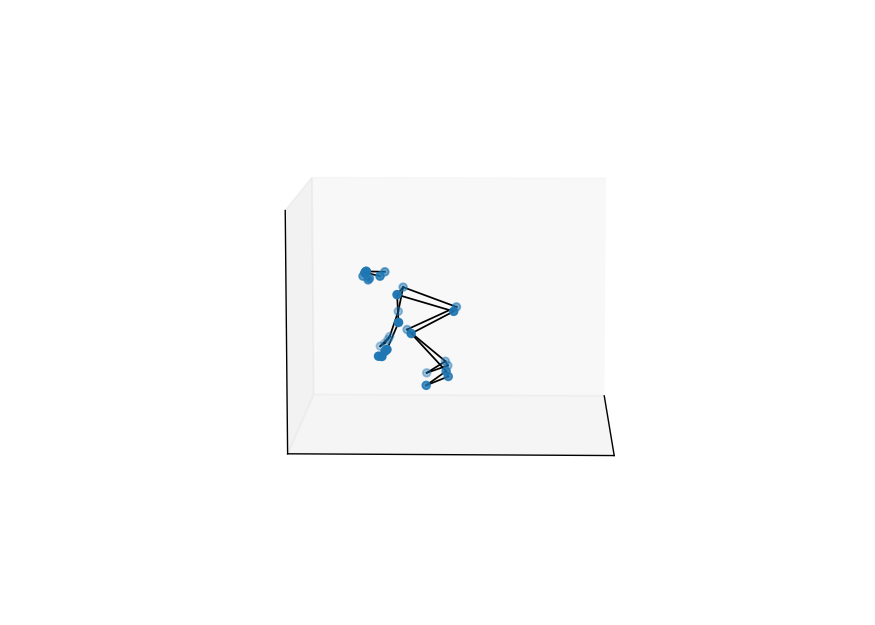

In [84]:
%matplotlib notebook

fig = plt.figure()
fig.set_size_inches(7, 5, True)
ax = fig.add_subplot(projection='3d')

anim = time_animate(data, fig, ax, rotate_animation=False)

# writer = animation.writers['ffmpeg']
# writer = writer(fps=30, bitrate=1800)
# anim.save('.//data/sample_data/deadlift_animation.mp4', writer=writer)